This is a jupyter notebook to demonstrate the functionality of the heron-BBH binary black hole surrogate model.
The surrogate model is conditioned on numerical relativity data produced by the Georgia Tech group.

In [1]:
import heron
from heron import waveform
from george import kernels
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/thesis-style.mpl")

In [3]:
import elk.catalogue

In [4]:
total_mass = 60

In [5]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo_cat = elk.catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95)

In [7]:
len(catalogue.waveforms)

162

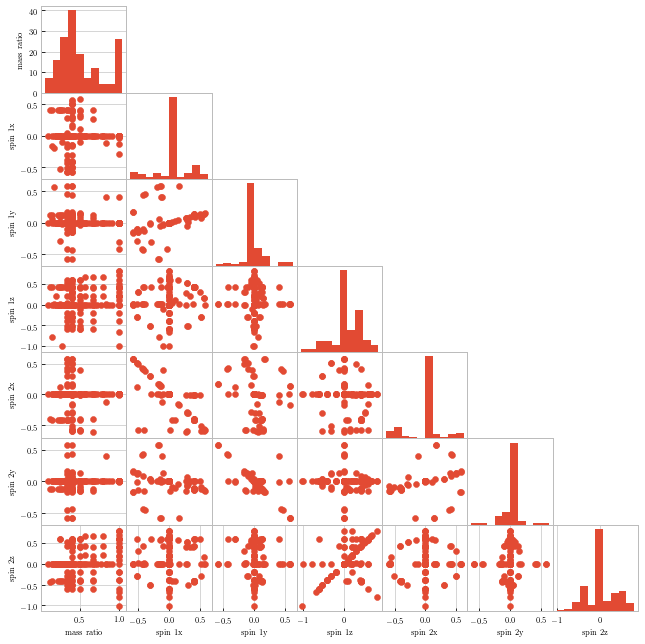

In [112]:
f = catalogue.coverage_plot()

In [113]:
f.savefig("coverage.pdf")

Define the Gaussian process model. There are separate kernel terms for the time axis, the mass axis, and each of the spin axes. These are all initialised with plausible length-scales.

This is used to build a `heron` Gaussian process 'catalogue', which is the interpolation object.

For this scenario the GPR is trained with waveforms sampled at 1,024-Hz, a minimum frequency of 95-Hz (which is chosen to allow all but one of the NR waveforms to be included in the training set), and a total CBC system mass of 60 solar masses.

A small quantity (with amplitude 1e-8) is added to the kernel to improve the numerical stability of the algorithm, and the HODLR matrix solver is used.

In [8]:
problem_dims = 8
c_ind = catalogue.c_ind
time_covariance = kernels.RationalQuadraticKernel(.05, 400,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
mass_covariance = kernels.ExpSquaredKernel(0.005, #0.09
#mass_covariance = kernels.Matern52Kernel(0.005, #0.09
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
spin_covariance = kernels.ExpSquaredKernel([0.005, 0.005, 0.005, 
#spin_covariance = kernels.Matern52Kernel([0.005, 0.005, 0.005, 
                                            0.005, 0.005, 0.005], 
                                           ndim=problem_dims, 
                                           axes=[2,3,4,5,6,7])

covariance =  1e1 * mass_covariance * time_covariance * spin_covariance

gp = gp_cat = waveform.GPCatalogue(catalogue, covariance,
                                   total_mass=total_mass, fsample=1024,
                                   mean=0.0,
                                   solver=None,
                                   white_noise=1e-8,
                                   fmin=95,)

There was an error producing a waveform for GT0392


In [10]:
len(gp.training_data)

4941

With the GPR object created the trained values for the hyperparameters are set. These were determined after 2,000 iterations of ADAM-based training on a much more powerful machine.

In [13]:
# After 2000 training iterations with ADAM
gp_cat.gp.set_parameter_vector(np.log([1.96628473e+00,
                                       3.33975754e-04,
                                       1.64245209e+00, 3.29722921e+02,
                                       8.78725810e-04, 7.28872939e-04, 6.98418530e-04,
                                       8.91739716e-04, 7.28836193e-04, 7.05170046e-04]))

We define a function to produce inspection plots which naively compare samples from the GPR to two different waveform approximant models.

In [14]:
def sample_plot(p, surrogates=True, phase_shift=(0,0)):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)
    
    if surrogates:
        imr = imr_cat.waveform(p=p,
                            time_range=[-150., 100., 1024],
                              coa_phase=phase_shift[0],
                              )
        seo = seo_cat.waveform(p=p,
                        time_range=[-150., 100., 1024],
                              coa_phase=phase_shift[1],)
        
    f, ax = plt.subplots(1,1, figsize=(10,5));
    waveforms = []
    for sample in samples:
        ax.plot(sample.times, sample.data/1e19, alpha=0.05, color='k');
        waveforms.append(sample.data)

    mean = np.array(waveforms).mean(axis=0)
        
    ax.plot(samples[0].times, mean/1e19, color="#7e25aa", label="GPR Mean")
        
    if surrogates:
        ax.plot(imr[0].times*1e4, imr[0].data, label="IMRPhenomPv2");
        ax.plot(seo[0].times*1e4, seo[0].data, label="SEOBNRv4");
        
    ax.set_xlabel("Times [msec] from merger");
    ax.set_ylabel("Strain (h+)");

    ax.legend();
    
    return f

## Calculating match

In [15]:
from functools import partial
ts = partial(seo_cat.waveform, p=p, time_range=[-150., 500., 1000])

In [16]:
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.optimize import minimize

In [17]:
def inner_product(x, y, sample_f, asd="LIGODesign", fmin=30, phase=0):
    """
    Calculate the inner product of two timeseries.


    Parameters
    ----------
    x : elk.Timeseries
       The timeseries sample from the Gaussian process
    y : elk.PNCatalogue, reduced
        The waveform thing. I need to sort this out properly.
    psd : np.ndarray or str or None
       The ASD to use to calculate the match. 
       Defaults to "LIGODesign" which is the LIGO design sensitivity.
    fmin : float
       The minimum frequency to be used to calculate the match.
    phase : float
       The phase shift, in radians, to apply to the second time series.
    
    """
    
    # Generate the data for x and y
    if isinstance(x, partial):
        x = x(coa_phase=phase)[0].data
    if isinstance(y, partial):
        y = y(coa_phase=phase)[0].data
    
    if asd=="LIGODesign":
        asd = np.loadtxt("fig1_aligo_sensitivity.txt")
    
    def pow2(x):
            """Find the next power of 2"""
            return 1 if x == 0 else 2**(int(x) - 1).bit_length()
    nfft = pow2(len(y)+np.abs(phase))
    freqs = np.linspace(0, sample_f/2, nfft)
    
    x_f = np.fft.fft(np.hamming(len(x))*x, n=nfft)#[freqs>30]
    y_f = np.fft.fft(np.hamming(len(y))*y, n=nfft) 
    asd_interp = interp1d(asd[:,0], asd[:,-2])
    integrand = ( (x_f[freqs>fmin]) * np.conj(y_f[freqs>fmin]) )  / asd_interp(freqs[freqs>fmin])**2
    integral = simps(integrand, x=freqs[freqs>30])
    return 4*np.real(integral)

def match(x, y, sample_f=1024, fmin=30, phase=0):
    top = inner_product(x,y, sample_f, phase=phase)
    bottom = np.sqrt(inner_product(x,x, sample_f, phase=phase) * inner_product(y,y, sample_f, phase=phase))
    return np.abs(top / bottom)

def optim_match(x,y, sample_f=1024, fmin=30):
    """
    Calculate the optimal match, maximised over the phase shift of the
    two waveforms.
    """
    def neg_match(phase, x,y,sample_f,fmin):
        #if np.abs(phase) > 0.3: return np.inf 
        return - match(x,y,sample_f,fmin,phase)

    phase_op = minimize(neg_match, x0=0, args=(x,y, sample_f, fmin))

    return -phase_op['fun'], phase_op['x']

In [18]:
from functools import partial
ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
#match(samples[0], )

# Sample Waveforms

## Non-spinning waveforms

Mass ratio: 0.1
Mass ratio: 0.2
Mass ratio: 0.3
Mass ratio: 0.4
Mass ratio: 0.5
Mass ratio: 0.6
Mass ratio: 0.7
Mass ratio: 0.8
Mass ratio: 0.9
Mass ratio: 1.0


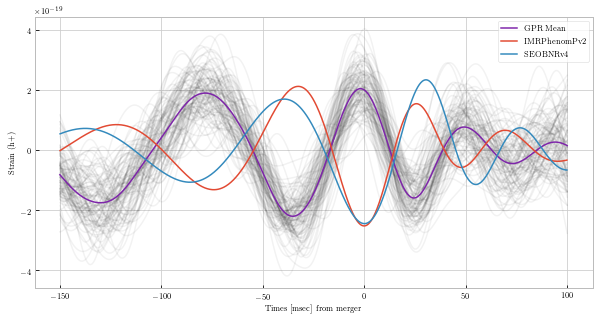

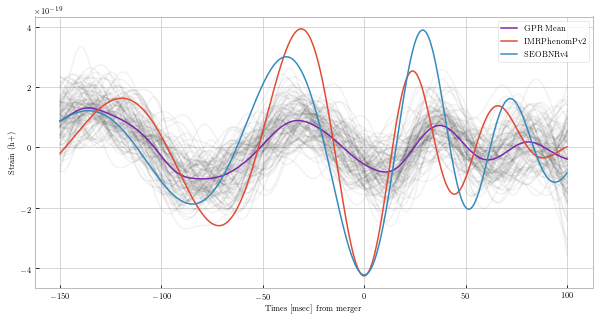

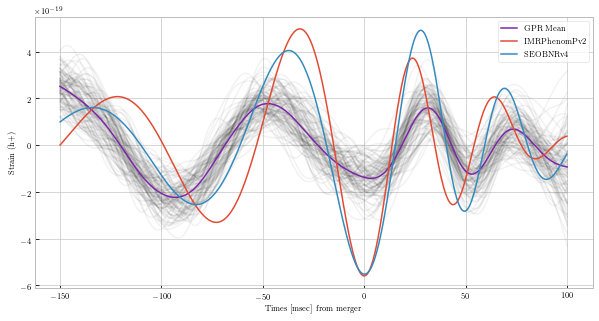

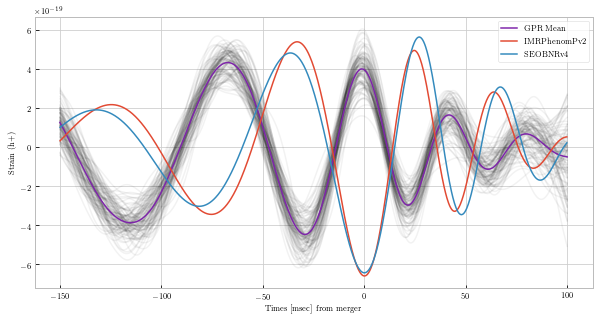

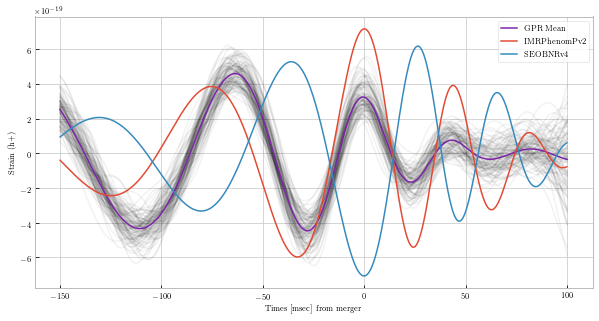

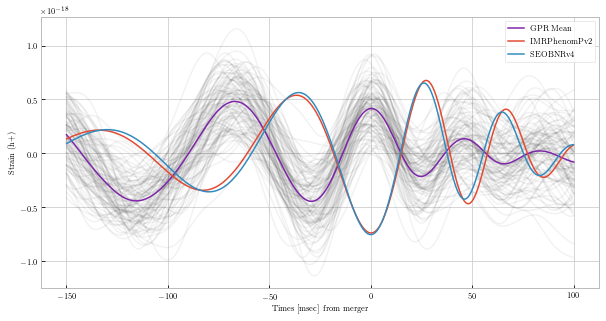

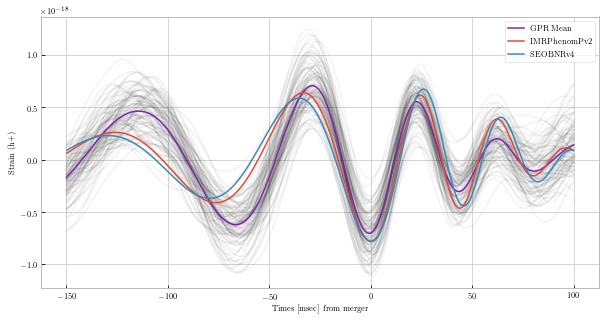

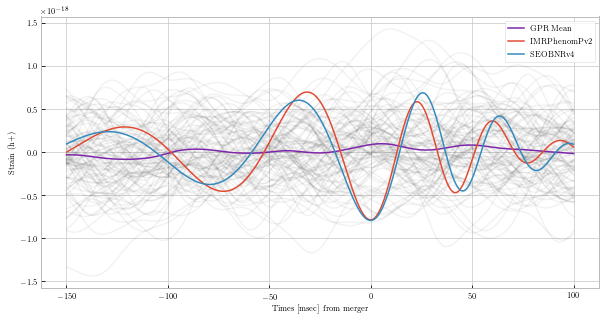

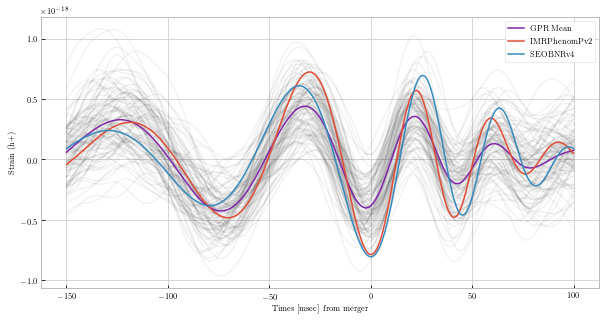

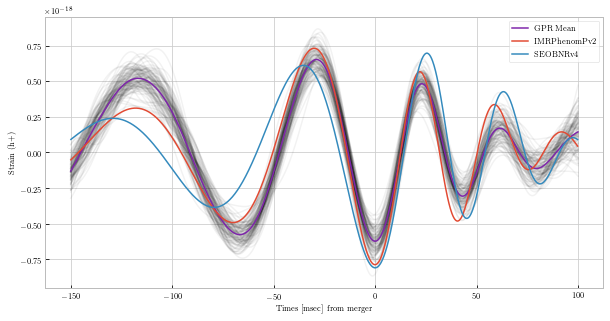

In [110]:
for mass_ratio in np.linspace(0.1,1,10):
    print("Mass ratio: {}".format(mass_ratio))
    sample_plot({"mass ratio": mass_ratio,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0,},)

## Anti-aligned spin waveform

/home/daniel/.virtualenvs/aries/heron-2714stable/lib/python2.7/site-packages/matplotlib-2.2.2-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


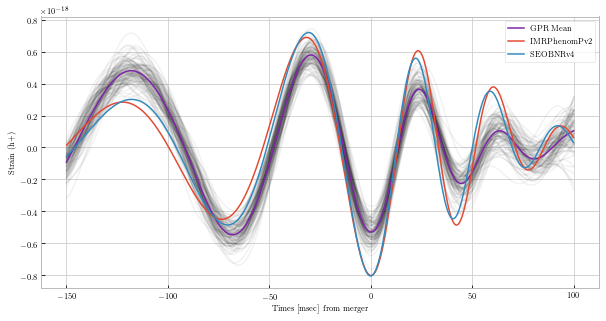

In [12]:
sample_plot({"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0.6,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": -0.6,},
           phase_shift = (0.25, 2.40)
           );

## Aligned spin waveforms

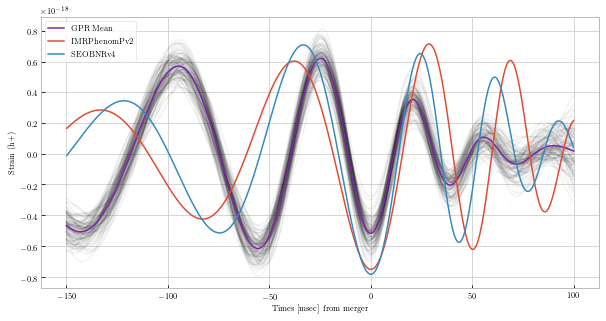

In [13]:
sample_plot({"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0.3,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0.3,},);

## Precessing waveforms

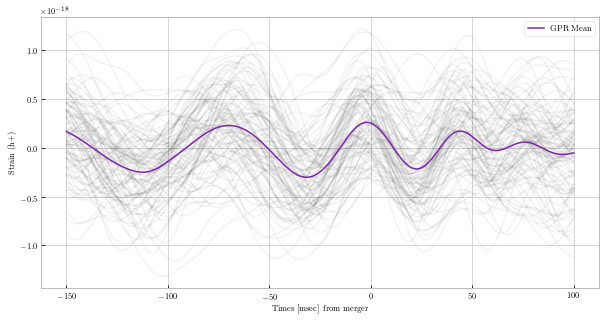

In [16]:
sample_plot({"mass ratio": 1,
                 "spin 1x": -0.15, "spin 1y": 0.4, "spin 1z": 0.4,
                 "spin 2x": -0.000, "spin 2y": -0.000, "spin 2z": 0.60,},
           surrogates=False,
           phase_shift = (0, 0.507));

In [92]:
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.40, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [19]:
# Poor interpolation point
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.80, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [20]:
from functools import partial
#ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])

In [21]:
waveform_imr = ts_imr(coa_phase=2.919)[0]

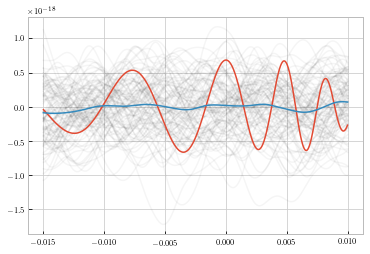

In [23]:
waveforms = []
for sample in samples:
    waveforms.append(sample.data)
    plt.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.04)
plt.plot(waveform_imr.times, waveform_imr.data)
waveforms = np.array(waveforms)
plt.plot(sample.times/1e4, waveforms.mean(axis=0)/1e19)

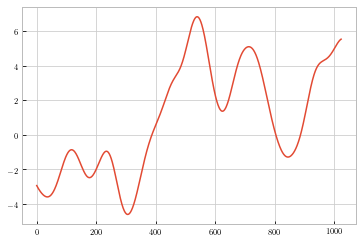

In [38]:
plt.plot(samples[50].data)

In [24]:
matches = []
waveforms = []    


for sample in samples:
    waveforms.append(sample.data)

# SEO and IMR-based calculations
waveform_imr = ts_imr(coa_phase=2.919)[0]
#waveform_seo = ts_seo(coa_phase=0.507)[0]
                     
mean = np.array(waveforms).mean(axis=0)
#times = np.linspace(-150, 100, 1024)/1e4

mean_match_imr = match(mean/1e21, ts_imr)
#mean_match_seo = match(-mean/1e21, ts_seo)

imr_matches = []
seo_matches = []

for sample in samples:
    imr_matches.append(match(sample.data, ts_imr, phase=2.855))
    #seo_matches.append(match(-sample.data, ts_seo, phase=0.507))
                     


In [25]:
from matplotlib.gridspec import GridSpec

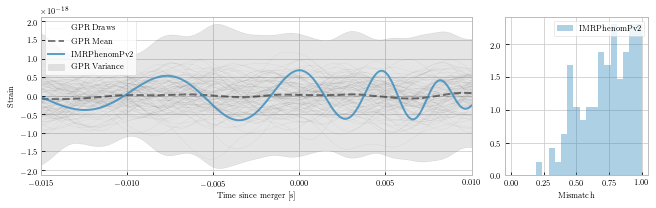

In [45]:
width = 4.5
height = width/1.618

f = plt.figure(constrained_layout=True, figsize=(2 * width, height))#, dpi=500)

gs = GridSpec(1,4, figure = f)

# Waveform plot
times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4
std = np.array(waveforms).std(axis=0)
ax_wave = f.add_subplot(gs[0:3])
ax_hist = f.add_subplot(gs[3])
for sample in samples[1:]:
    ax_wave.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.0525, lw=0.5)
ax_wave.plot(samples[0].times/1e4, samples[0].data/1e19, color='k', alpha=0.0525, lw=0.5, label="GPR Draws")
ax_wave.plot(times, mean/1e19, label = "GPR Mean", 
             linestyle="--",
             alpha=0.5, color='k', lw=2)
ax_wave.fill_between(times, (mean+std**2)/1e19, (mean-std**2)/1e19, alpha=0.1, color='k', label="GPR Variance")
    
# SEOBNRv4
#ax_wave.plot(waveform_seo.times, -waveform_seo.data, label="SEOBNRv4", lw=2, alpha=0.8)
# IMRPhenomPv2
ax_wave.plot(waveform_imr.times, waveform_imr.data, label="IMRPhenomPv2", 
             lw=2, alpha=0.8, color="#348ABD")

ax_wave.legend()

times = samples[0].times/1e4 #np.linspace(-150, 100, 1024)/1e4

ax_wave.set_xlim([-0.015, 0.01])


#ax_hist.hist(1.0 - np.array(seo_matches), range=(0,.1), bins=11, 
#             density=True, histtype="stepfilled", alpha=0.4, label="SEOBNRv4")
ax_hist.hist(1.0 - np.array(imr_matches), 
             range=(0,1.0), 
             density=True,
             bins=21, 
             histtype="stepfilled", 
             alpha=0.4,
             color="#348ABD",
             label="IMRPhenomPv2"
            )
ax_hist.legend()
#ax_hist.vlines(x=[1-mean_match_imr, 1-mean_match_seo], ymax=35, ymin=0,
#              color=['blue', 'red'])

ax_wave.set_xlabel("Time since merger [s]")
ax_hist.set_xlabel("Mismatch")
ax_wave.set_ylabel("Strain")
#f.tight_layout()
f.savefig("poor-fit.pdf")

In [78]:
from functools import partial
#ts_seo = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])
ts_imr = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
#match(samples[0], )

matches_seo = []
matches_imr = []
for phase in np.linspace(0, 2*np.pi, 100):
    matches_seo.append(match(mean/1e19, ts_seo, phase=phase))
    matches_imr.append(match(mean/1e19, ts_imr, phase=phase))
matches_seo = np.array(matches_seo)
matches_imr = np.array(matches_imr)

In [79]:
print(np.linspace(0, 2*np.pi, 100)[matches_seo.argmax()])
print(np.linspace(0, 2*np.pi, 100)[matches_imr.argmax()])

0.5077321460347141
2.8559933214452666


In [91]:
print(np.linspace(0, 2*np.pi, 100)[matches.argmax()])

2.9194598396996057


In [88]:
p = {"mass ratio": 1,
                 "spin 1x": -0.12, "spin 1y": 0.40, "spin 1z": 0.425,
                 "spin 2x": -0.001, "spin 2y": -0.004, "spin 2z": 0.60,}

waveforms = []
for sample in samples:
    waveforms.append(sample.data)
    #plt.plot(sample.times/1e4, sample.data/1e19, color='k', alpha=0.04)
    
waveforms = np.array(waveforms)
#plt.plot(sample.times/1e4, waveforms.mean(axis=0)/1e19)

ts = partial(imr_cat.waveform, p=p, time_range=[-150., 100., 1024])
mean = waveforms.mean(axis=0)
matches = []
for phase in np.linspace(0, 2*np.pi, 100):
    matches.append(match(mean/1e19, ts, phase=phase))
matches = np.array(matches)

In [85]:
p = {"mass ratio": .1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0,}
samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 100, 1024], samples=100)

In [25]:
ts = partial(seo_cat.waveform, p=p, time_range=[-150., 100., 1024])

In [26]:
matches = []
for sample in samples:
    matches.append(match(sample.data, ts, phase=1.90))

(array([16., 23., 18.,  9., 10.,  4.,  1.,  4.,  0.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

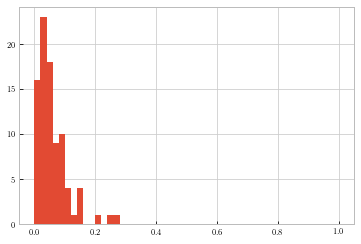

In [27]:
plt.hist(1-np.array(matches), bins=50, range=(0,1))

In [28]:
neg_match = lambda x: -match(samples[0].data/1e19, ts, phase=x)

In [29]:
match(samples[0].data/1e19, ts, phase=1.5)

0.9030291439690815

In [30]:
from scipy.optimize import basinhopping
basinhopping(neg_match, x0=1.9)

KeyboardInterrupt: 

In [ ]:
neg_match(3)

In [ ]:
imr = imr_cat.waveform(p=p, coa_phase=0,
                            time_range=[-150., 100., 1024])
imr_1 = imr_cat.waveform(p=p, coa_phase=1.9,
                            time_range=[-150., 100., 1024])
seo = seo_cat.waveform(p=p, coa_phase=1.6,
                            time_range=[-150., 100., 1024])
for sample in samples:
    plt.plot(sample.times/1e4, sample.data/1e19, alpha=0.05, color='k')

#plt.plot(imr[0].times, imr[0].data)
plt.plot(imr_1[0].times, imr_1[0].data)
plt.plot(seo[0].times, seo[0].data)
